In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5.8)

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
df = pd.read_csv("../data/dset_08-12.csv")
_s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]
_seq = df[_s_idx:_s_idx+25][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
_seq.i_m1sum /= 1000
_seq.power_consumption /= 1000
_seq

,i_m1sum,power_consumption,thermal_consumption_kwh,demand_price,feedin_price,kwh_eq_state
9285,1.246,0.197,0.0000,0.45,0.150000,8.8044
9286,1.017,0.063,0.0000,0.45,0.150000,8.7290
9287,1.115,0.089,0.0000,0.45,0.150000,8.7580
9288,0.845,0.324,0.0000,0.45,0.150000,8.8682
9289,0.615,0.075,0.0000,0.45,0.150000,8.9204
9290,0.560,0.055,0.0000,0.45,0.150000,8.9320
9291,0.551,0.043,0.0000,0.45,0.150000,8.9552
9292,0.534,0.074,0.0000,0.45,0.150000,9.0944
9293,0.505,0.065,0.0000,0.45,0.150000,8.9494
9294,0.399,0.062,0.0000,0.47,0.156667,9.2162


In [4]:
print(df.kwh_eq_state.max())
print(df.mean_temperature.mean())

10.764799999999996
48.88151492925039


In [5]:
max_storage_tank = df.kwh_eq_state.max()
optimum_storage = 40*1.16*0.3
gamma = 0.035


In [6]:
def build_trees(levels):

    tree = np.zeros(2**(levels+1)-1,)
    tree[::2] =1
    tree = np.insert(tree, 0, 0)
    tree = np.insert(tree, 0, 0)

    res_sum = np.zeros(len(tree))
    states = np.zeros(len(tree))

    return tree, states, res_sum

In [7]:
def step(s, thermal_consumption, a):
    '''
    action = [0; 82.53]
    '''
    cool_down = 0.1 
    heat_increase = a - cool_down
    s_1 = s + heat_increase - thermal_consumption
    
    if s_1 > max_storage_tank:
        s_1 = max_storage_tank
        
    return s_1

In [8]:
def reward(action, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state):
    
    kwh_increase = action
    
    if state+kwh_increase > max_storage_tank:
        kwh_increase = max_storage_tank - state
    
    '''
    ! VORZEICHEN DER VARIABLEN !
    '''
    
    diff = pv_excess - kwh_increase - power_consumption - thermal_consumption    
        
    if diff < 0:
        reward = -(diff * demand_price + (kwh_increase - diff) * feedin_price)
    else:
        reward = -(kwh_increase * feedin_price)  + diff * feedin_price
        
        
    '''
    PENALTY FOR DISTANCE TO OPTIMUM
    '''
    reward -= abs(state - optimum_storage)*gamma
    
    
    return reward

In [9]:
def simulate(levels, seq, exploit=False):

    tree, states, res_sum = build_trees(levels)

    start_capacity = seq.kwh_eq_state.to_list()[0]
    states[0] = start_capacity


    nodes = 1
    r = 0
    level_idx = 0 

    for i in range(levels): 

        level_idx = r  
        print(i,level_idx)

        seq_row = seq.iloc[i]

        pv_excess = seq_row.i_m1sum
        demand_price = seq_row.demand_price
        feedin_price = seq_row.feedin_price
        power_consumption = seq_row.power_consumption
        thermal_consumption = abs(seq_row.thermal_consumption_kwh)


        for n in range(nodes):
            
            root = tree[r]
            result_root = res_sum[r]
            state_root = states[r]
            
            
            left = tree[r*2 +1]
            right = tree[r*2 +2]

            if exploit: 
                right = pv_excess - power_consumption - thermal_consumption 
            
            '''
            reward(action, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state)
            '''
            
            res_sum[r*2 +1] = result_root + reward(left, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state_root)
            res_sum[r*2 +2] = result_root + reward(right,pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state_root)
            
            '''
            step(s, thermal_consumption, a)
            '''
            
            states[r*2 +1] = step(state_root, thermal_consumption, left)
            states[r*2 +2] = step(state_root, thermal_consumption, right)
            
            
            r +=1
            
        nodes *= 2

    return res_sum, states, tree, level_idx

levels = 19

rewards, states, tree, f_level_idx = simulate(levels,_seq)

0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143


In [10]:
def backtrack_seq(tree, states, idx, levels):
    seq = []
    state_seq = []
    for i in range(levels):
        action_tmp = tree[int(idx)]
        
        if i == 0:
            seq.append(action_tmp)
            state_seq.append(start_capacity)
        
        if action_tmp == 0:
            i_add = -1
        if action_tmp == 1:
            i_add = -2
        
        idx = (idx + i_add)/2 
        a = tree[int(idx)]
        s = states[int(idx)]

        seq.append(a)
        state_seq.append(s)
    
    return np.flip(seq), np.flip(state_seq)

In [13]:
f_rewards = rewards[f_level_idx:-3]
b_i = f_rewards.argmax() 

seq_, state_seq_ = backtrack_seq(tree, states, b_i + f_level_idx , levels)


print("sum rewards: ", f_rewards[b_i])
print("f_idx: ", b_i, " of ", len(f_rewards))
print(seq_, sum(seq_))
print(states[b_i+f_level_idx])
print(state_seq_)

print(states)

NameError: name 'start_capacity' is not defined

In [17]:



plt.plot(state_seq_[:-1])


NameError: name 'state_seq_' is not defined

In [14]:
x = 4
start_capacity+x*0.8-(19-x)*0.2

NameError: name 'start_capacity' is not defined

In [15]:
def pipe(n_samples=30, random=False, exploit=False):

    reward_list = []

    _s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]

    for i in range(n_samples):
        _seq = df[_s_idx:_s_idx+100][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
        _seq.i_m1sum /= 1000
        _seq.power_consumption /= 1000


        rewards, states, tree, f_level_idx = simulate(levels,_seq, exploit=exploit)
        f_rewards = rewards[f_level_idx:-3]
        b_i = f_rewards.argmax() 
        if random:
            b_i = np.random.choice(np.arange(f_rewards.size))


        reward_list.append(rewards[b_i + f_level_idx])

        _s_idx +=96

    return reward_list


In [15]:
_n = 30

reward_list = pipe(n_samples=_n)
reward_list_r = pipe(n_samples=_n, random=True)
reward_list_exploit = pipe(n_samples=_n, exploit=True)

0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65

KeyboardInterrupt: 

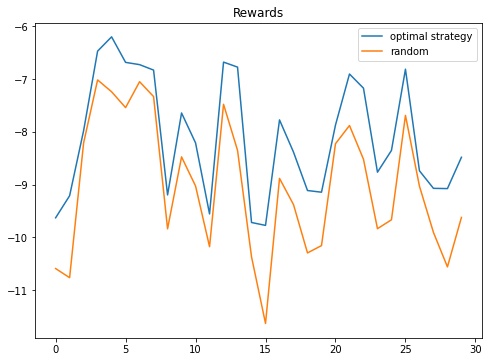

In [ ]:
plt.plot(reward_list, label="optimal strategy")
plt.plot(reward_list_r, label="random")
plt.title("Rewards")
plt.legend()
plt.show()

In [ ]:
def simulate_reward_mypv(pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state):
    

    kwh_increase = pv_excess - power_consumption - thermal_consumption  

    if kwh_increase < 0: 
        kwh_increase = 0

    if state+kwh_increase > max_storage_tank:
        kwh_increase = max_storage_tank - state
    
    '''
    ! VORZEICHEN DER VARIABLEN !
    '''

    diff = pv_excess - kwh_increase - power_consumption - thermal_consumption    
        
    if diff < 0:
        reward = -(diff * demand_price + (kwh_increase - diff) * feedin_price)
    else:
        reward = -(kwh_increase * feedin_price)  + diff * feedin_price
        
        
    '''
    PENALTY FOR DISTANCE TO OPTIMUM
    '''
    reward -= abs(state - optimum_storage)*gamma
    
    
    return kwh_increase, reward


def pipe_mypv(n_samples=30, levels=levels):

    reward_list = []

    _s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]

    for i in range(n_samples):
        _seq = df[_s_idx:_s_idx+20][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
        _seq.i_m1sum /= 1000
        _seq.power_consumption /= 1000

        reward_ = 0
        state = _seq["kwh_eq_state"].iloc[0]

        for i in range(levels):

            seq_row = _seq.iloc[i]

            pv_excess = seq_row.i_m1sum
            demand_price = seq_row.demand_price
            feedin_price = seq_row.feedin_price
            power_consumption = seq_row.power_consumption
            thermal_consumption = abs(seq_row.thermal_consumption_kwh)
            
            action_, reward_tmp = simulate_reward_mypv(pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state)
            
            print(state)
            reward_ += reward_tmp
            
            state = step(state, thermal_consumption, action_)

        reward_list.append(reward_)

        _s_idx += 96
    
    return reward_list

In [23]:
reward_list_mypv = pipe_mypv()

8.8044
9.7534
10.607399999999998
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
6.130599999999999
6.063599999999999
6.5836
7.1126
8.3166
9.8646
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
8.9958
9.913799999999998
10.3774
10.548399999999999
10.664799999999996
10.664799999999996
10.606799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.664799999999996
10.635799999999996
10.635799999999996
10.664799999999996
10.664799999999996
10.606799999999996
10.641599999999997
10.664799999999996
10.664799999999996
10.103599999999

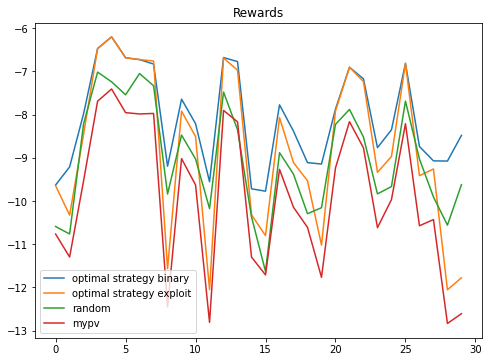

In [24]:
plt.plot(reward_list, label="optimal strategy binary")
plt.plot(reward_list_exploit, label="optimal strategy exploit")
plt.plot(reward_list_r, label="random")
plt.plot(reward_list_mypv, label="mypv")
plt.title("Rewards")
plt.legend()
plt.show()


In [37]:
np.ones(2**30)   # 8GB RAM equivalent

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
for t in range(n_trees)

<h1>Simulation Concatenated Tree<h1>

In [93]:
def pipe_concat(n_samples=30, n_trees=1, random=False, exploit=False):

    reward_list = []
    b_i_list = []
    trees_list = []
    states_list = []

    _s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]

    for i in range(n_samples):
        _seq = df[_s_idx:_s_idx+100][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
        _seq.i_m1sum /= 1000
        _seq.power_consumption /= 1000

        seq_splits = np.array_split(_seq, n_trees)

        for t in range(n_trees):

            seq_split = seq_splits[t]
            if t != 0:
                seq_split.kwh_eq_state.iloc[0] = last_state

            rewards, states, tree, f_level_idx = simulate(levels, seq_split, exploit=exploit)
            f_rewards = rewards[f_level_idx:-3]
            b_i = f_rewards.argmax() 
            if random:
                b_i = np.random.choice(np.arange(f_rewards.size))

            b_i_list.append(b_i + f_level_idx)
            reward_list.append(rewards[b_i + f_level_idx])
            trees_list.append(tree)
            states_list.append(states)
            last_state = states[b_i + f_level_idx]

        _s_idx +=96

    return np.array(reward_list).reshape(n_samples, n_trees ), np.array(b_i_list).reshape(n_samples, n_trees), np.array(trees_list).reshape(n_samples, n_trees, len(tree)), np.array(states_list).reshape(n_samples, n_trees, len(tree))

In [94]:
rewards, bi_list, trees_list, states_list = pipe_concat(n_samples=1, n_trees=5)

0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143


In [101]:
states = []
for i in range(5):
    _seq, _states = backtrack_seq(trees_list[0][i], states_list[0][i], bi_list[0][i], levels)
    states.append(_states[:-1])


In [147]:
states[0]


8.8044

In [2]:
from importlib import reload
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5.8)
import sys
sys.path.insert(0, 'C:/Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data')
import datafactory
reload(datafactory)
from datafactory import DataSet
plt.rcParams["figure.figsize"] = (20,8)

dataset = DataSet(start_date="2022-01-01", target="i_m1sum", scale_target=False, scale_variables=False, time_features=False, resample=None,dynamic_price=False, demand_price=0.5, feedin_price=0.5).pipeline()
dataset = dataset[["date", "i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
print("Mean:")
print(dataset.mean())
print("Max:")
print(dataset.max())
print("len: ", len(dataset))
dataset.head()

0.07637132957990407 1.272


C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values
C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values


Mean:
i_m1sum                     0.396229
power_consumption           0.076040
thermal_consumption_kwh     0.073875
demand_price                0.500000
feedin_price                0.500000
kwh_eq_state               10.976822
dtype: float64
Max:
date                       2022-08-19 05:30:00
i_m1sum                                  2.369
power_consumption                        1.272
thermal_consumption_kwh              11.666537
demand_price                               0.5
feedin_price                               0.5
kwh_eq_state                         18.526926
dtype: object
len:  21837


C:\Users\lukas\AppData\Local\Temp\ipykernel_6716\4087985098.py:14: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(dataset.mean())


,date,i_m1sum,power_consumption,thermal_consumption_kwh,demand_price,feedin_price,kwh_eq_state
0,2022-01-01 00:15:00,0.0,0.0,0.000000,0.5,0.5,9.922370
1,2022-01-01 00:30:00,0.0,0.0,0.193796,0.5,0.5,9.767333
2,2022-01-01 00:45:00,0.0,0.0,0.251935,0.5,0.5,9.515398
3,2022-01-01 01:00:00,0.0,0.0,0.058139,0.5,0.5,9.457259
4,2022-01-01 01:15:00,0.0,0.0,0.019380,0.5,0.5,9.437880


0.07637132957990407 1.272
{'max_storage_tank': 35.96859259259259, 'optimum_storage': 32.37173333333333, 'gamma1': 4.025, 'gamma2': 0.1, 'gamma3': 0.0, 'demand_price': 0.4, 'feedin_price': 0.1}
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191


C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values
C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values


14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
25.833046296296295
33.41048148148148
[array([25.8330463, 26.9820463, 28.5200463, 30.4020463, 31.9430463,
       31.8430463, 32.3790463, 32.2790463, 32.1790463, 32.0790463,
       32.8000463, 32.7000463, 32.6000463, 32.5000463, 32.4000463,
       32.5850463, 32.4850463, 32.3850463, 32.2850463]), array([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.]), -0.5223562037036943]
[array([33.41048148, 33.11668519, 32.88102778, 32.66475   , 32.52599074,
       32.42599074, 32.32599074, 32.22599074, 32.12599074, 32.02599074,
       31.92599074, 32.58723148, 32.42909259, 32.29033333, 32.11281481,
       32.37125926, 32.2325    , 32.03560185, 31.8387037 ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0.]), 7.490942685185184]


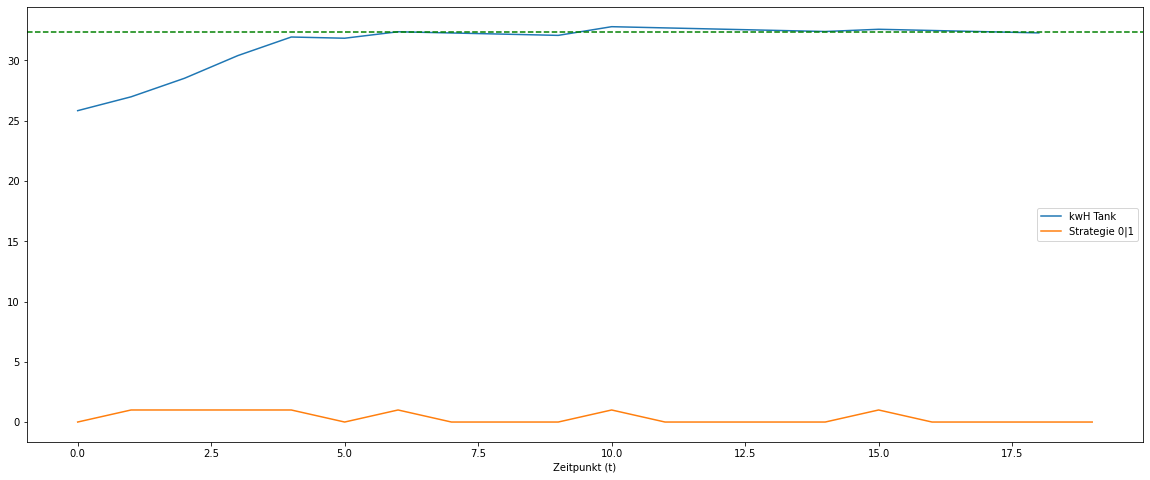

In [16]:
import simulations
reload(simulations)
from simulations import Tree, Experiment, Experiment_Concat

levels = 19

args = {
    "max_storage_tank": dataset.kwh_eq_state.max(),
    "optimum_storage":dataset.kwh_eq_state.max() * 0.9,
    "gamma1": 4.025,    # financial
    "gamma2": 0.1,      # distance optimum
    "gamma3": 0.0,      # tank change
    "demand_price": 0.4,
    "feedin_price": 0.1
}

dataset = DataSet(start_date="2022-01-01", target="i_m1sum", scale_target=False, scale_variables=False, time_features=False, dynamic_price=False, demand_price=args["demand_price"], feedin_price=args["feedin_price"]).pipeline()
dataset = dataset[["date", "i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]

e = Experiment(levels, n_samples=2, dataset=dataset, args=args, exploit=True, start_date="2022-05-08 10:45:00") 


res = e.results()
plt.plot(res[0][0], label="kwH Tank")
plt.axhline(y=args["optimum_storage"], color='g', linestyle='--')
plt.plot(res[0][1], label="Strategie 0|1")
plt.xlabel("Zeitpunkt (t)")
plt.legend()
print(res[0])
print(res[1])



0.07637132957990407 1.272
{'max_storage_tank': 35.96859259259259, 'optimum_storage': 32.37173333333333, 'gamma1': 0.025, 'gamma2': 0.9, 'gamma3': 0.1, 'demand_price': 0.4, 'feedin_price': 0.1}
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191


C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values
C:\Users/lukas/OneDrive - Johannes Kepler Universität Linz/Projekte/DLinear/data\datafactory.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.thermal_consumption[idx_temp] = abs(m_diff[m_diff < 0])   # only positive values


14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
[array([25.8330463, 26.9820463, 28.5200463, 30.4020463, 30.3020463,
       30.2020463, 30.7380463, 30.6380463, 31.9710463, 31.8710463,
       31.7710463, 31.6710463, 32.7600463, 32.6600463, 32.5600463,
       32.7450463, 32.6450463, 32.5450463, 32.4450463]), array([32.3450463 , 32.3450463 , 32.2450463 , 32.5070463 , 32.4070463 ,
       32.01635185, 32.11635185, 32.01635185, 31.91635185, 31.81635185,
       31.76635185, 31.69835185, 31.59

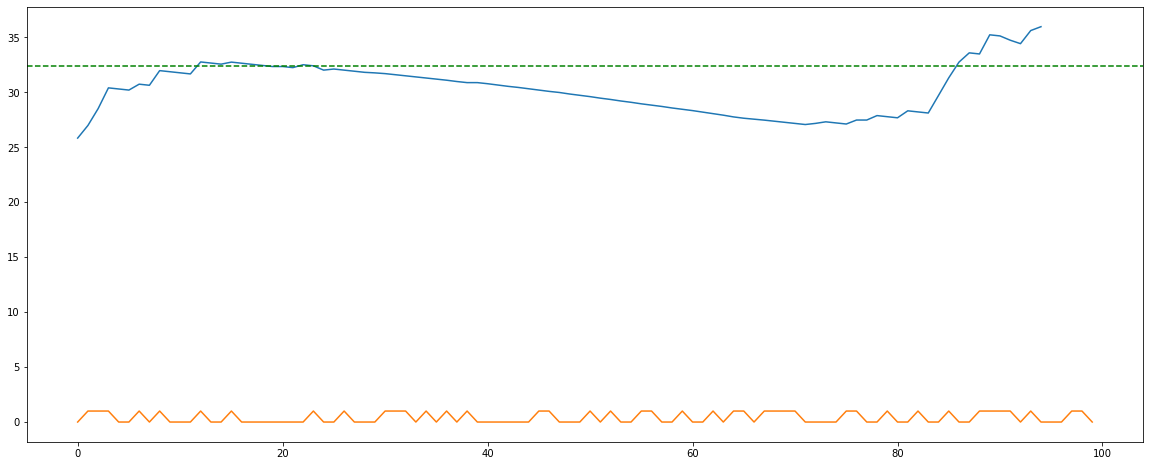

In [20]:
args = {
    "max_storage_tank": dataset.kwh_eq_state.max(),
    "optimum_storage":dataset.kwh_eq_state.max() * 0.9,
    "gamma1": 0.025,    # financial
    "gamma2": 0.9,      # distance optimum
    "gamma3": 0.1,      # tank change
    "demand_price": 0.4,
    "feedin_price": 0.1
}


dataset = DataSet(start_date="2022-01-01", target="i_m1sum", scale_target=False, scale_variables=False, time_features=False, dynamic_price=False, demand_price=args["demand_price"], feedin_price=args["feedin_price"]).pipeline()
dataset = dataset[["date", "i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]

e = Experiment_Concat(levels, n_samples=1, dataset=dataset, args=args, exploit=True, random=True, start_date="2022-05-08 10:45:00", n_trees=5) 


res = e.results_concat()


plt.plot(np.array(res[0]).flatten())
plt.axhline(y=args["optimum_storage"], color='g', linestyle='--')
plt.plot(np.array(res[1]).flatten())
print(res[0])
print(res[1])

[array([7.7314, 7.7314, 7.6314, 7.5314, 7.4314, 7.3314, 7.2314, 7.1314,
       7.0314, 6.9314, 6.8314, 6.7314, 6.6314, 6.5314, 6.4314, 6.3314,
       6.2314, 6.1314, 6.0314]), array([5.9314  , 5.9314  , 5.8314  , 5.731762, 5.63201 , 5.44501 ,
       5.34501 , 5.24501 , 5.14501 , 5.045048, 4.945098, 4.84513 ,
       4.745133, 4.645133, 4.545133, 4.445133, 4.345133, 4.245133,
       4.139333]), array([4.039333, 4.039333, 3.939333, 3.833533, 3.727733, 3.627733,
       3.521933, 3.416133, 3.310333, 3.210333, 3.098733, 2.992933,
       2.887133, 2.775533, 2.669733, 2.558133, 2.452333, 2.340733,
       2.234933]), array([2.129133, 2.129133, 2.017533, 1.911733, 1.805933, 1.694333,
       1.582733, 1.471133, 1.353733, 1.247933, 1.147933, 1.047933,
       0.947933, 0.847933, 0.747933, 0.647933, 0.547933, 0.447933,
       0.347933]), array([ 0.247933,  0.247933,  0.147933,  0.047933, -0.052067, -0.152067,
       -0.252067, -0.352067, -0.452067, -0.552067, -0.652067, -0.752067,
       -0.852067, 

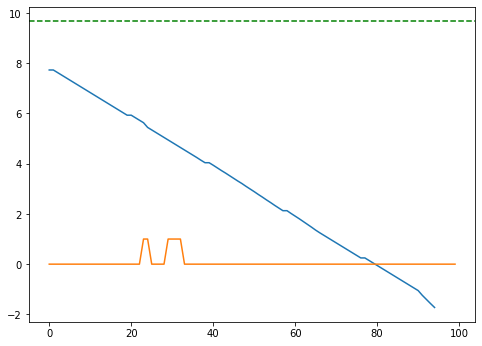

https://www.edureka.co/community/18855/numpy-multiplying-large-arrays-with-dtype-int8-is-slow

In [63]:
d = np.ones(2**20, dtype="u1")
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000)

d = np.ones(2**20, dtype="float32")
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000, "| Tracked time demo run: 40sec")

d = np.ones(2**20)
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000, "| Tracked time demo run: 13sec")

Memory size of numpy array in MB: 1.048576
Memory size of numpy array in MB: 4.194304 | Tracked time demo run: 40sec
Memory size of numpy array in MB: 8.388608 | Tracked time demo run: 13sec
